### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, train_test_split_and_balance
from src.data_loader import BinaryBRSETDataset
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES_PATH = os.path.join(DATASET, 'images/')
LABEL = 'diabetic_retinopathy'
TEST_SIZE = 0.3
UNDERSAMPLE = False

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

BACKBONE = 'dinov2_base'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = None # 756
num_classes = 2

BATCH_SIZE = 512
NUM_WORKERS = 4


LOSS = 'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 30
learning_rate = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df.head()

loading csv file in /home/opc/Retina/BRSET//labels.csv


,image_id,patient_id,camera,patient_age,comorbidities,diabetes_time_y,insuline,patient_sex,exam_eye,diabetes,...,vascular_occlusion,hypertensive_retinopathy,drusens,hemorrhage,retinal_detachment,myopic_fundus,increased_cup_disc,other,quality,normality
0,img00001,1,Canon CR,48.0,diabetes1,12,yes,1,1,yes,...,0,0,0,0,0,0,1,0,Adequate,abnormal
1,img00002,1,Canon CR,48.0,diabetes1,12,yes,1,2,yes,...,0,0,0,0,0,0,1,0,Adequate,abnormal
2,img00003,2,Canon CR,18.0,diabetes1,7,yes,2,1,yes,...,0,0,0,0,0,0,0,0,Adequate,normal
3,img00004,2,Canon CR,18.0,diabetes1,7,yes,2,2,yes,...,0,0,0,0,0,0,0,0,Adequate,normal
4,img00005,3,Canon CR,22.0,diabetes1,11,yes,1,1,yes,...,0,0,0,0,0,0,0,0,Adequate,normal


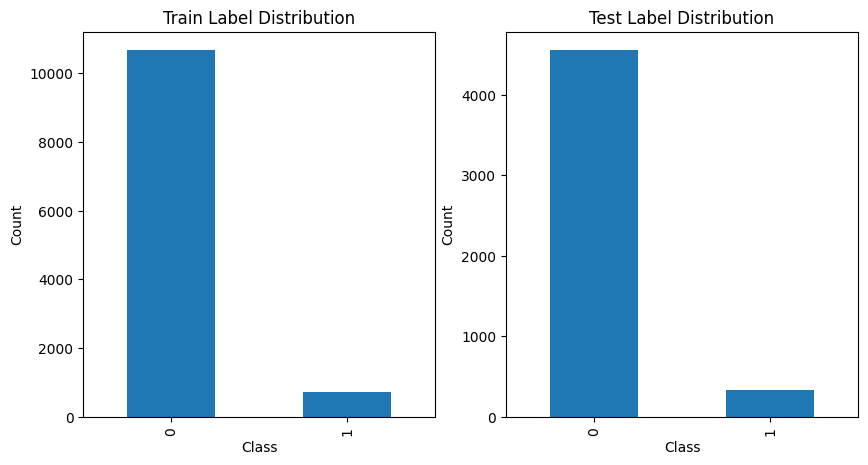

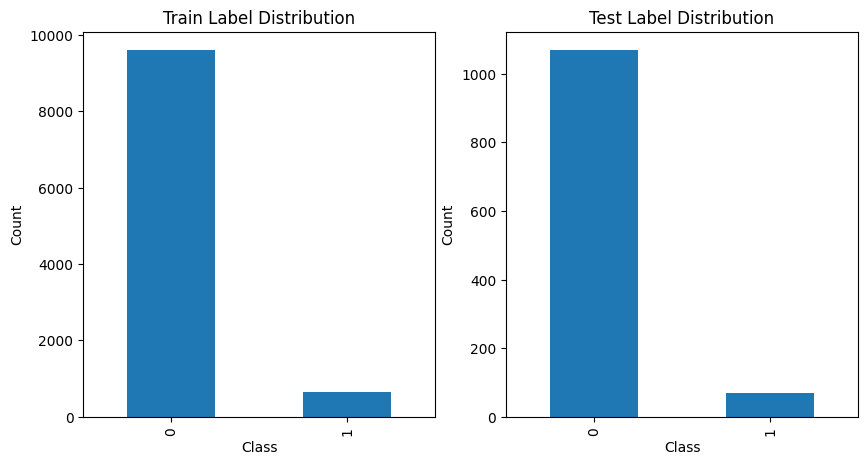

In [4]:
# Usage
df_train, df_test = train_test_split_and_balance(df, LABEL, TEST_SIZE, undersample=UNDERSAMPLE)
df_train, df_val = train_test_split_and_balance(df_train, LABEL, 0.1, undersample=UNDERSAMPLE)

### Dataloaders

In [5]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [6]:
# Create the custom dataset
train_dataset = BinaryBRSETDataset(
    folder_path=IMAGES_PATH,
    dataframe=df_train,
    shape=SHAPE,
    transform=train_transforms,
    label_col=LABEL
)

test_dataset = BinaryBRSETDataset(
    folder_path=IMAGES_PATH,
    dataframe=df_test,
    shape=SHAPE,
    transform=test_transform,
    label_col=LABEL
)

val_dataset = BinaryBRSETDataset(
    folder_path=IMAGES_PATH,
    dataframe=df_val,
    shape=SHAPE,
    transform=test_transform,
    label_col=LABEL
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [7]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels

for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [ ]:
# Create a DataLoader to generate embeddings
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using cache found in /home/opc/.cache/torch/hub/facebookresearch_dinov2_main


Using 2 GPUs!


### Training:

In [ ]:
if LOSS == 'focal_loss':
    criterion = BinaryFocalLoss(alpha=2, gamma=2)  # Focal Loss
else:
    criterion = nn.BCEWithLogitsLoss()  #nn.BCELoss()  # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

100%|██████████| 81/81 [03:13<00:00,  2.38s/it]


Epoch 1, Training Loss: 0.3847647960539217


100%|██████████| 9/9 [00:26<00:00,  2.94s/it]


Epoch 1, Validation Loss: 0.3230919771724277, F1 Score: 1.0


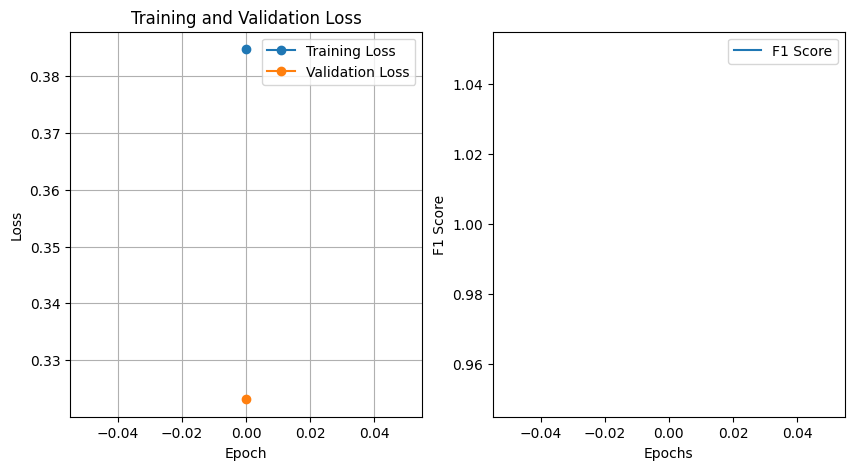

Training finished.


In [ ]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=False, device=device)

### Test

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import torch 
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os

# Metrics
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay

# Generate Saliency Maps
def get_saliency_map(model, input_image):
    model.eval()
    input_image.requires_grad_()
    output = model(input_image)
    max_idx = output.argmax()
    output[0, max_idx].backward()
    saliency_map, _ = torch.max(input_image.grad.data.abs(),dim=1)
    #saliency_map = input_image.grad.data.abs().max(1)[0]
    return saliency_map

def test_model(y_test, y_pred):
    """
    Evaluates the model on the training and test data respectively
    1. Predictions on test data
    2. Classification report
    3. Confusion matrix
    4. ROC curve

    Inputs:
    y_test: numpy array with test labels
    y_pred: numpy array with predicted test labels
    """
    
    plot_matrix = False
    if y_pred.shape[1] < 102:
        plot_matrix = True
        
    
    if y_pred.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)
        y_pred = np.argmax(y_pred, axis=1)
    
    # Confusion matrix
    # Create a confusion matrix of the test predictions
    if plot_matrix:
        cm = confusion_matrix(y_test, y_pred)
        # create heatmap
        # Set the size of the plot
        fig, ax = plt.subplots(figsize=(15, 15))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax)
        # Set plot labels
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        # Display plot
        plt.show()

    #create ROC curve
    from sklearn.preprocessing import LabelBinarizer
    fig, ax = plt.subplots(figsize=(15, 15))

    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)
    y_onehot_pred = label_binarizer.transform(y_pred)
    
    if (y_onehot_pred.shape[1] < 2):
        fpr, tpr, _ = roc_curve(y_test,  y_pred)

        #create ROC curve
        #plt.plot(fpr,tpr)
        RocCurveDisplay.from_predictions(
                y_test,
                y_pred,
                name=f"ROC curve",
                color='aqua',
                ax=ax,
            )
        plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
        plt.title('ROC Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    else:
        from itertools import cycle
        colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "yellow", "purple", "pink", "brown", "black"])

        for class_id, color in zip(range(len(label_binarizer.classes_)), colors):
            RocCurveDisplay.from_predictions(
                y_onehot_test[:, class_id],
                y_onehot_pred[:, class_id],
                name=f"ROC curve for {label_binarizer.classes_[class_id]}",
                color=color,
                ax=ax,
            )

        plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)
        plt.show()
        
    # Classification report
    # Create a classification report of the test predictions
    cr = classification_report(y_test, y_pred)
    # print classification report
    print(cr)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  # Use weighted average for multi-class precision
    recall = recall_score(y_test, y_pred, average='weighted')  # Use weighted average for multi-class recall
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use weighted average for multi-class F1-score

    return accuracy, precision, recall, f1


def test(model, test_dataloader, saliency=True, device='cpu'):

    model.to(device)
    model.eval()

    output_size = test_dataloader.dataset.labels.shape[1]
    num_classes = 2 if test_dataloader.dataset.labels.shape[1] == 1 else test_dataloader.dataset.labels.shape[1]

    eval_images_per_class = {i: [] for i in range(num_classes)}
    
    with torch.no_grad():
        y_true, y_pred = [], []
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            image, labels =  batch['image'].to(device), batch['labels'].to(device)

            outputs = model(image)

            if (output_size == 1):
                preds = torch.sigmoid(outputs)
            else:
                preds = torch.softmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            # Get 5 images per class for saliency maps
            for i in range(num_classes):
                if len(eval_images_per_class[i]) < 5:
                    if (output_size == 1):
                        eval_images_per_class[i] += [img for i, img in enumerate(image) if labels[i] == i]
                    else:
                        eval_images_per_class[i] += [img for i, img in enumerate(image) if np.argmax(labels[i], axis=1) == i]
                    
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        
        if (output_size == 1):
            y_pred_one_hot = (y_pred > 0.5).astype(int)
        else:
            predicted_class_indices = np.argmax(y_pred, axis=1)
            # Convert the predicted class indices to one-hot encoding
            y_pred_one_hot = np.eye(y_pred.shape[1])[predicted_class_indices]
        
        test_model(y_true, y_pred_one_hot)
    
    if saliency:
        
        print('#' * 50, f' Saliency Maps ', '#' * 50)
        print('')

        # Select some evaluation images to generate saliency maps
        eval_images = []
        for img_class in eval_images_per_class.keys():
            eval_images = eval_images_per_class[img_class][:5]

            print(f'Class {img_class}:')

            for eval_image in eval_images:
                eval_image = eval_image.unsqueeze(0)  # Add batch dimension
                saliency_map = get_saliency_map(model, eval_image)

                # Plot original image and saliency map side by side
                plt.figure(figsize=(10, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(eval_image[0].permute(1, 2, 0).detach().cpu().numpy())
                plt.title(f'Original Image (Class {img_class})')
                
                plt.subplot(1, 2, 2)
                plt.imshow(saliency_map[0].detach().cpu().numpy(), cmap=plt.cm.hot)
                plt.title('Saliency Map')
                
                plt.tight_layout()
                plt.show()



100%|██████████| 39/39 [01:30<00:00,  2.31s/it]


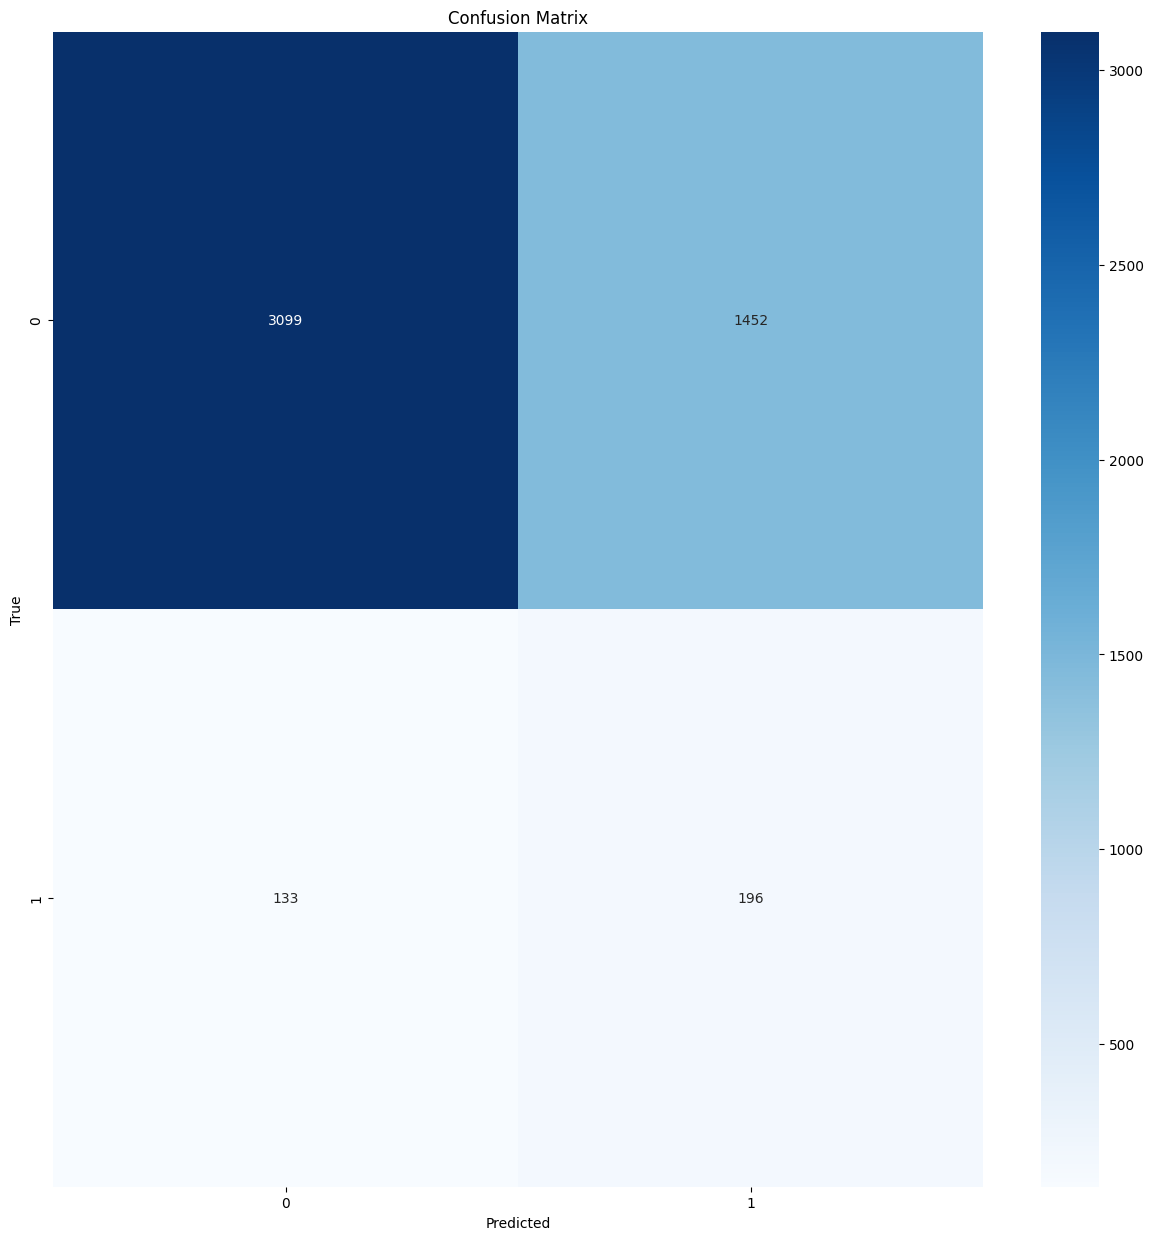

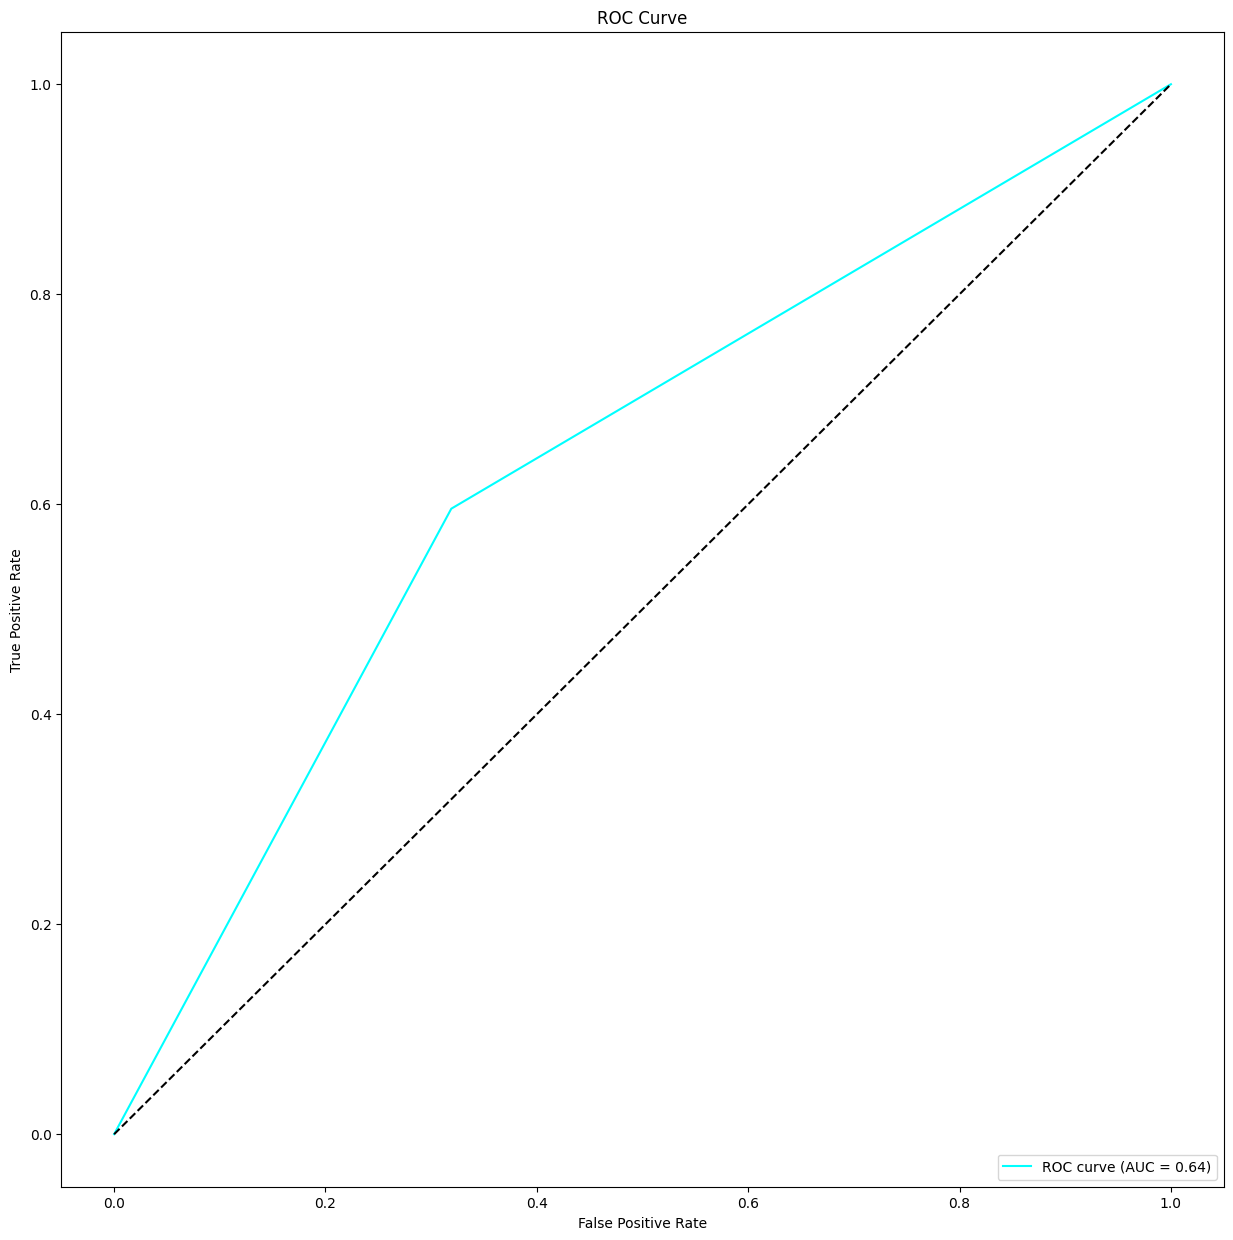

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80      4551
         1.0       0.12      0.60      0.20       329

    accuracy                           0.68      4880
   macro avg       0.54      0.64      0.50      4880
weighted avg       0.90      0.68      0.76      4880

##################################################  Saliency Maps  ##################################################

Class 0:


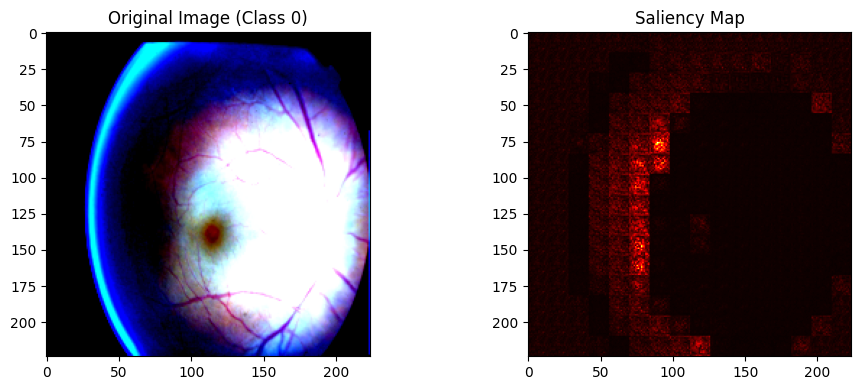

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


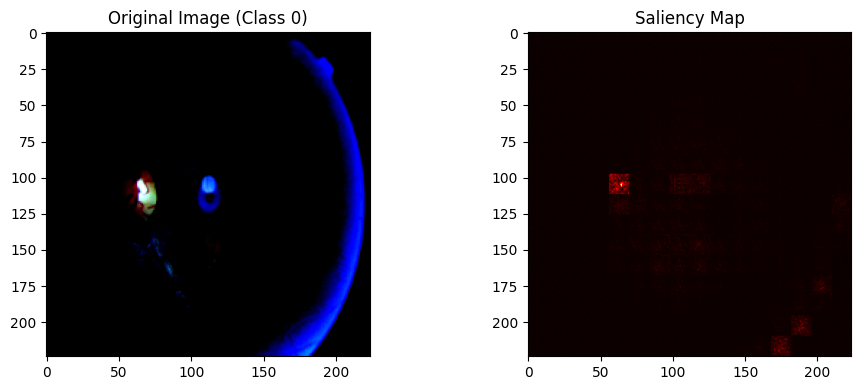

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


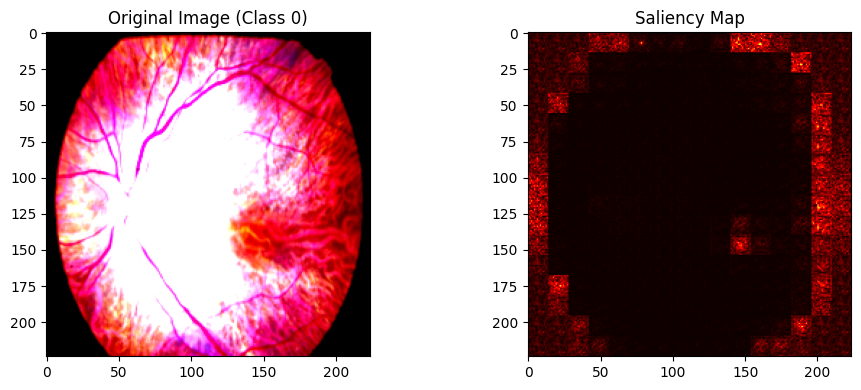

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


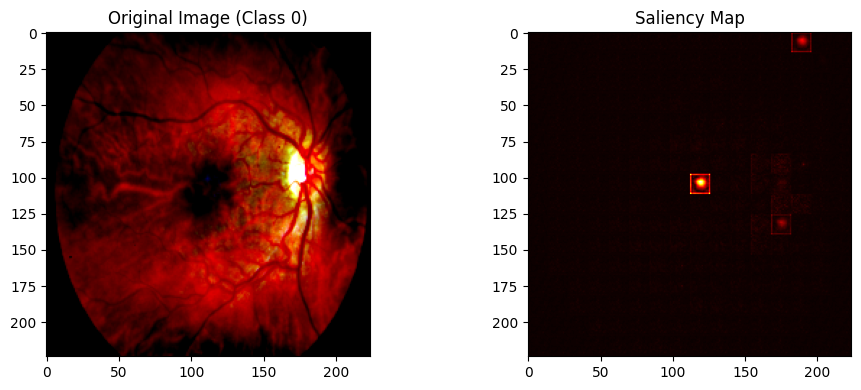

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


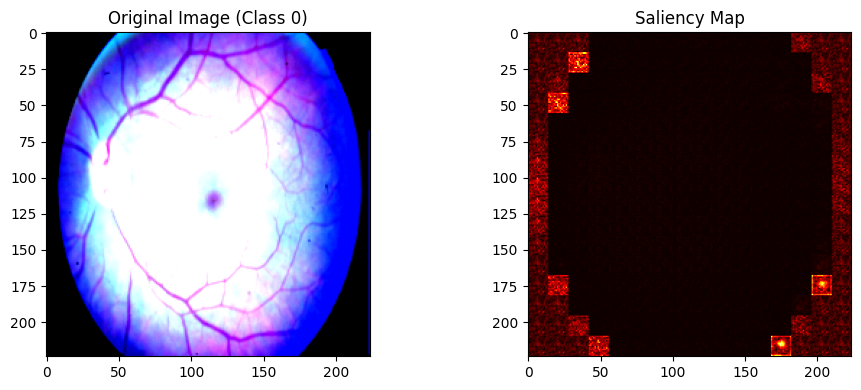

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


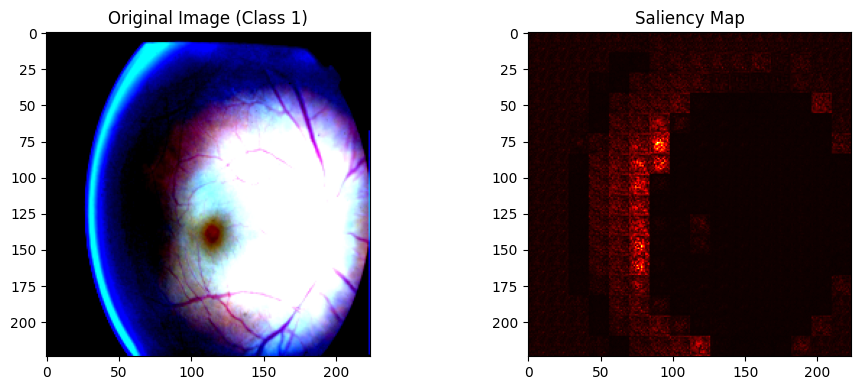

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


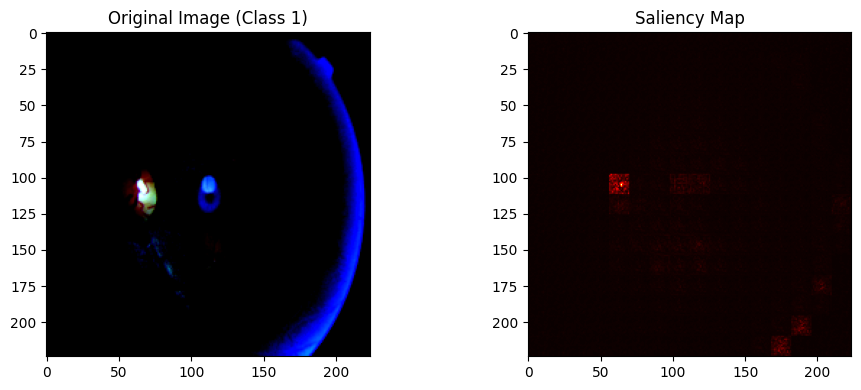

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


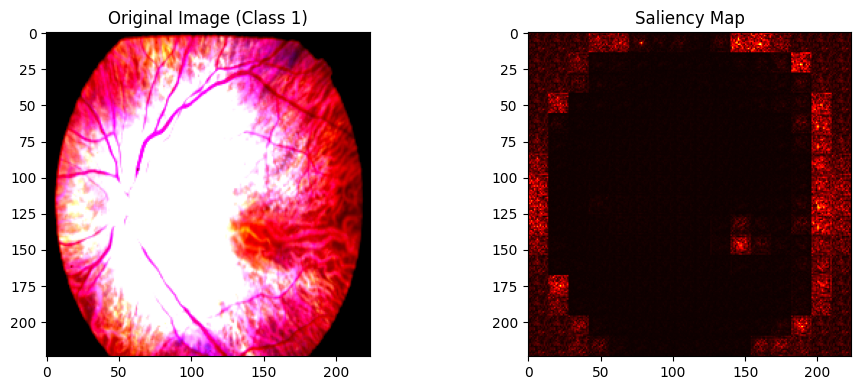

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


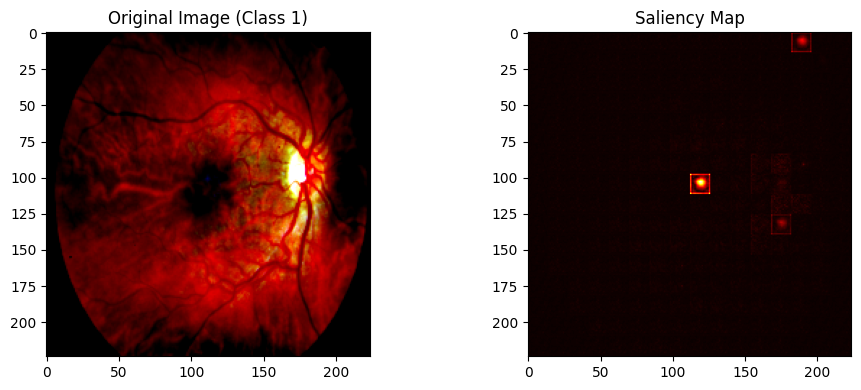

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


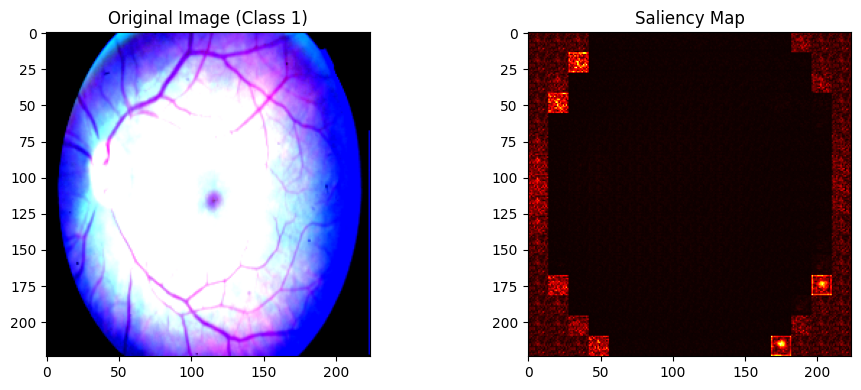

: 

In [ ]:
test(model, test_dataloader, saliency=True, device=device)